### 필요 Functions

In [67]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import random
import os
import warnings
import matplotlib.pyplot as plt # 득점모델 변수 중요도
import seaborn as sns

warnings.filterwarnings("ignore")

def visual_df(train):
    feature_selection = [f for f in train.columns if train[f].isnull().sum()<30000 and f != 'customer_country.1']
    train = train[feature_selection]
    feature_summary = pd.DataFrame(train.dtypes, columns=["Data Type"])
    feature_summary.reset_index(inplace=True)
    feature_summary.rename(columns={'index': 'Feature 이름'}, inplace=True)
    feature_summary['고유값 수'] = train.nunique().values
    feature_summary['결측값 수'] = train.isnull().sum().values
    return feature_summary
    

def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    
seed_everything()

def get_clf_eval(y_test, y_pred=None):

    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

def log_transform(data,cols):
    for col in cols :
        data[col]=np.log1p(data[col]) 
    return data 

def label_encoding(series):
    # """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}
    # 모든 요소를 문자열로 변환
    mode = np.flip(series.value_counts().index.values)
    # unique value 찾고 아스키코드 기준으로 sort
    # my_dict을 통해 unique value에 대응하는 label 생성 
    for idx, value in enumerate(mode):
        my_dict[value] = idx
    # my_dict의 index와 매치되는 series값을 my_dict의 value로 변환한다.
    series = series.map(my_dict)

    return series

def same_word_detect(df, categorical_list):
    for feature in categorical_list:
        df[feature] = df[feature].str.lower()
        # 특수문자를 대체 문자열 지정
        replacement = {'/': '', 
                       '-':'', 
                       '_':'', 
                       ' ':'', 
                       '~':'',
                       '&':'',
                       '.':'',
                       ',':''}
        # replace() 함수를 사용하여 특수 문자 대체
        df[feature].replace(replacement, inplace=True)
    return df

def preprocessing(train, test):

    label_columns = [feature for feature in train.columns if train[feature].dtype=='O' or feature == 'lead_owner' ]
    

    df_all = pd.concat([train[label_columns], test[label_columns]])
    df_all = df_all.astype(str)
    df_all = same_word_detect(df_all, label_columns)
    temp = df_all
 
    
    # label encoding
    for col in label_columns:
        df_all[col] = label_encoding(df_all[col])
    # test set 분리 
    for col in label_columns:  
        train[col] = df_all.iloc[: len(train)][col]
        test[col] = df_all.iloc[len(train) :][col]
    
    # 결측값 처리
    train = train.fillna(0)
    test = test.fillna(0)
    
    return train, test

def model_train(train, test, model):

    train, test = preprocessing(train, test)
    x_train, x_val, y_train, y_val = train_test_split(
    train.drop("is_converted", axis=1),
    train["is_converted"],
    test_size=0.2,
    stratify=train["is_converted"],
    shuffle=True,
    random_state=42,)
    
    model = model
    model.fit(x_train, y_train)
    pred = model.predict(x_val)
    metrics = get_clf_eval(y_val, pred)
    print(f'validaion에서 true: {sum(pred)}')
    print(metrics)

    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=x_train.columns)
    ftr_top = ftr_importances.sort_values(ascending=False)[:20]
    print(ftr_top[:5])
    plt.figure(figsize=(8, 6))
    sns.barplot(x=ftr_top, y=ftr_top.index)
    plt.show()
    return model, metrics

### Flip (즉, 최빈값)

오차행렬:
 [[  759   211]
 [  223 10667]]

정확도: 0.9634
정밀도: 0.7729
재현율: 0.7825
F1: 0.7777
validaion에서 true: 982
None
customer_idx          0.473466
lead_owner            0.109207
lead_desc_length      0.070684
customer_type         0.057003
response_corporate    0.047417
dtype: float64


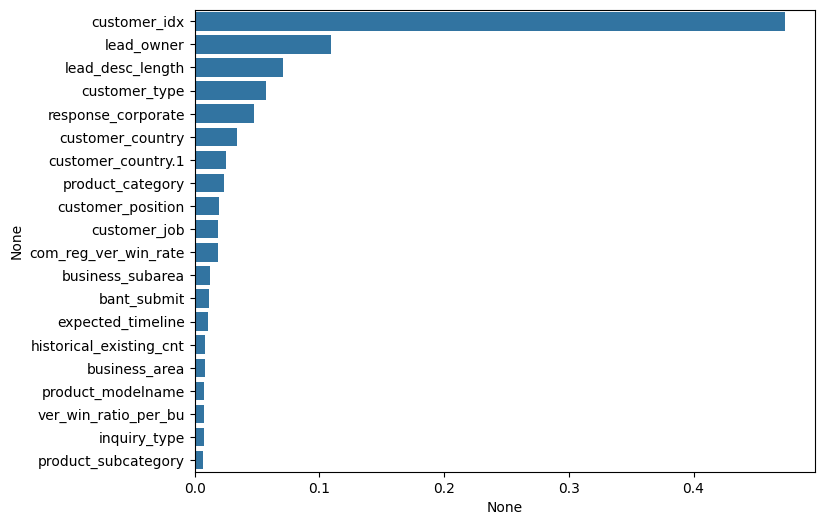

578


In [46]:
train = pd.read_csv('/home/workspace/LGamiers/EDA/train.csv')
test = pd.read_csv("/home/workspace/LGamiers/Model/submission.csv")

train, test = preprocessing(train, test)
model = DecisionTreeClassifier(random_state=400)
model, metrics = model_train(train, test, model)
# 예측에 필요한 데이터 분리
x_test = test.drop(["is_converted", 'id'], axis=1)
test_pred_1 = model.predict(x_test)
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("/home/workspace/LGamiers/Model/submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

print(sum(test_pred))

### Feature selection

오차행렬:
 [[  725   245]
 [  246 10644]]

정확도: 0.9586
정밀도: 0.7467
재현율: 0.7474
F1: 0.7470
validaion에서 true: 971
None
customer_idx          0.516996
lead_owner            0.141844
lead_desc_length      0.072496
customer_country      0.066795
response_corporate    0.066367
dtype: float64


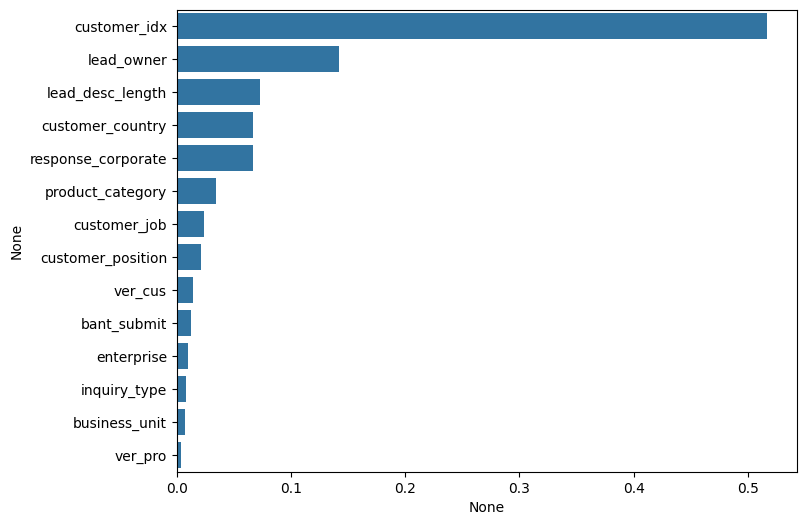

696


In [68]:
train = pd.read_csv('/home/workspace/LGamiers/EDA/train.csv')
test = pd.read_csv("/home/workspace/LGamiers/Model/submission.csv")
feature_selection = [f for f in train.columns if train[f].isnull().sum()<30000 and f != 'customer_country.1']
# feature_selection = ["customer_idx", "lead_owner", "response_corporate", "lead_desc_length", "customer_country", 'is_converted']
train = train[feature_selection]
test = test[feature_selection]

train, test = preprocessing(train, test)
model = DecisionTreeClassifier()
model, metrics = model_train(train, test, model)
# 예측에 필요한 데이터 분리
x_test = test.drop(["is_converted"], axis=1)
test_pred = model.predict(x_test)

# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("/home/workspace/LGamiers/Model/submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)
print(sum(test_pred))

In [63]:
# label encoding에 추가
print(train['customer_idx'].value_counts())

customer_idx
38735    7686
38734    2421
38733     367
38732     331
38731     162
         ... 
3378        1
3377        1
3376        1
3375        1
22824       1
Name: count, Length: 35112, dtype: int64


In [69]:
# label encoding에 삭제
print(train['customer_idx'].value_counts())

customer_idx
47466    7686
25096    2421
37680     367
18030     331
21321     162
         ... 
39487       1
41241       1
39422       1
22515       1
30268       1
Name: count, Length: 35112, dtype: int64


In [95]:
for idx in df_sub['customer_idx'].value_counts().index:
    if len(train[train['customer_idx'] == idx]) == 0:
        continue
    print('---------   ',str(idx), ' 의 분포이다. ')
    temp = train[train['customer_idx'] == idx]
    if len(temp['is_converted'].value_counts()) == 2:
        series = temp['is_converted'].value_counts()
        index_1 = series.index[0]
        index_2 = series.index[1]
        value_1 = series.values[0]
        value_2 = series.values[1]
        print("-------훈련 데이터의 분포 -------")
        print(index_1 , "  " , str(value_1))
        print(index_2 , "  " , str(value_2))
    else:
        series = temp['is_converted'].value_counts()
        index_1 = series.index[0]
        value_1 = series.values[0]
        print("-------훈련 데이터의 분포 -------")
        print(index_1 , "  " , str(value_1))

    temp_2 = df_sub[df_sub['customer_idx'] == idx]
    
    if len(temp_2['is_converted'].value_counts()) == 2:
        series = temp_2['is_converted'].value_counts()
        index_1 = series.index[0]
        index_2 = series.index[1]
        value_1 = series.values[0]
        value_2 = series.values[1]
        print("-------테스트 예측 데이터의 분포 -------")
        print(index_1 , "  " , str(value_1))
        print(index_2 , "  " , str(value_2))
    else:
        series = temp_2['is_converted'].value_counts()
        index_1 = series.index[0]
        value_1 = series.values[0]
        print("-------테스트 예측 데이터의 분포 -------")
        print(index_1 , "  " , str(value_1))
    print('\n')


---------    47466  의 분포이다. 
-------훈련 데이터의 분포 -------
False    7619
True    67
-------테스트 예측 데이터의 분포 -------
False    339
True    24


---------    9324  의 분포이다. 
-------훈련 데이터의 분포 -------
True    14
-------테스트 예측 데이터의 분포 -------
False    118
True    2


---------    23341  의 분포이다. 
-------훈련 데이터의 분포 -------
True    1
-------테스트 예측 데이터의 분포 -------
True    22
False    9


---------    37680  의 분포이다. 
-------훈련 데이터의 분포 -------
False    363
True    4
-------테스트 예측 데이터의 분포 -------
False    12
True    2


---------    11685  의 분포이다. 
-------훈련 데이터의 분포 -------
False    1
-------테스트 예측 데이터의 분포 -------
False    11
True    2


---------    21321  의 분포이다. 
-------훈련 데이터의 분포 -------
False    161
True    1
-------테스트 예측 데이터의 분포 -------
False    11


---------    869  의 분포이다. 
-------훈련 데이터의 분포 -------
False    1
-------테스트 예측 데이터의 분포 -------
False    10


---------    22433  의 분포이다. 
-------훈련 데이터의 분포 -------
True    1
-------테스트 예측 데이터의 분포 -------
False    9


---------    21156  의 분포이다. 
------

In [93]:
len(train[train['customer_idx'] == 100])

1

In [87]:
temp = train[train['customer_idx'] == 37680]
len(temp['is_converted'].value_counts())

2

In [85]:
df_sub['customer_idx'].value_counts().index

Index([47466,  9324, 23341, 26303, 37680, 11685, 21321,   869, 28290, 35824,
       ...
       30709,  6157, 12511, 36870, 46629, 17207, 43943, 40326,  9859, 23646],
      dtype='int64', name='customer_idx', length=4069)

In [83]:
temp_2 = df_sub[df_sub['customer_idx'] == 37680]
temp_2['is_converted'].value_counts()

is_converted
False    12
True      2
Name: count, dtype: int64

In [38]:
print(test['customer_idx'].value_counts())

customer_idx
38735    363
38729    120
38711     31
38667     14
38733     14
        ... 
29074      1
29073      1
29085      1
29100      1
0          1
Name: count, Length: 4069, dtype: int64


In [42]:
df_sub['customer_idx'].value_counts()

customer_idx
47466    363
9324     120
23341     31
26303     14
37680     14
        ... 
17207      1
43943      1
40326      1
9859       1
23646      1
Name: count, Length: 4069, dtype: int64

In [96]:
67/7619

0.008793804961281008

In [97]:
24/339

0.07079646017699115